# Solve the Field Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as inte
import scipy.constants as c

import axion_mass
from config import model
import g_star
import time_temp
import T_osc_solver

In [2]:
debug = False

#energy_unit = 1 # 1e-10 # eV
#time_unit = 1 # 1 / eV
temperature_unit = 1e12 # eV

def axion_eom_T_rhs(T, y, f_a, m_a_fn, g_model):
    """
    Computes the rhs of the eom of the axion field as a function of the temperature,
    given the temperature in eV, y = [theta(T), dtheta/dT(T)], g_model is a GStarModel,
    m_a_fn : T x f_a -> m_a [eV]
    """
    theta, dthetadT = y 
    assert np.isfinite(theta) 
    H = time_temp.hubble_parameter_in_rad_epoch(T * temperature_unit, g_model)
    dtdT = time_temp.dtdT(T * temperature_unit, g_model) * temperature_unit
    d2tdT2 = time_temp.d2tdT2(T * temperature_unit, g_model) * temperature_unit**2 
    m_a = m_a_fn(T * temperature_unit, f_a)
    d2thetadT2 = - (3 * H * dtdT - d2tdT2 / dtdT) * dthetadT - m_a**2 * dtdT**2 * np.sin(theta)
    if debug:
        print("----------------------------------")
        print("T =", T * temperature_unit / 1e6, "MeV")
        print("theta =", theta)
        print("dtheta/dT =" ,dthetadT)
        print("d2thetadT2 =", d2thetadT2)
        print("H =",H)
        print("dtdT =",dtdT)
        print("d2tdT2 =", d2tdT2)
        print("m_a**2 =", m_a, "** 2 =", m_a**2)
    return dthetadT, d2thetadT2

In [3]:
def sim_axion_field_evo_T(theta_i, f_a, m_a_fn, g_model, from_T_osc=5, to_T_osc=0.2, num_pts_to_return=400):
    """
    Solve the EOM for the axion field. Takes the initial field value theta_i, the axion decay constant f_a,
    the axion mass as a function of temperature m_a_fn : f_a x T -> m_a and the model
    the the eff. rel. dof. : GStarModel.
    Returns the temperature and the field values
    """
    T_osc = T_osc_solver.find_T_osc(f_a, m_a_fn, g_model)
    T_range = (from_T_osc * T_osc / temperature_unit, to_T_osc * T_osc / temperature_unit)
    T = np.linspace(*T_range, num_pts_to_return)
    sol = inte.solve_ivp(lambda T, y: axion_eom_T_rhs(T, y, f_a, m_a_fn, g_model), 
                         T_range, (theta_i, 0), t_eval=T)
    return T * temperature_unit, sol.y[0, :]

T_osc = [  9.84112560e+08]


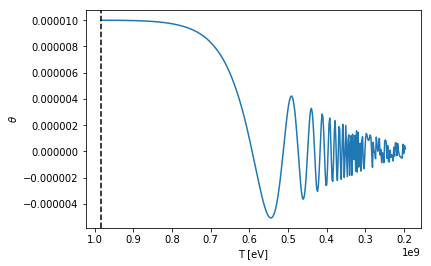

In [12]:
f_a = 1e12 * 1e9
m_a_fn = axion_mass.m_a_from_chi_general
g_model = g_star.borsamyi_table
theta_i = 1e-5
T, phi = sim_axion_field_evo_T(theta_i, f_a, m_a_fn, g_model, from_T_osc=1)
plt.plot(T, phi)
plt.xlabel("T [eV]")
plt.ylabel(r"$\theta$")
T_osc = T_osc_solver.find_T_osc(f_a, m_a_fn, g_model)
plt.axvline(T_osc, color="black", linestyle="--")
print("T_osc =", T_osc)
plt.gca().invert_xaxis()